In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.stats import multivariate_normal
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation

In [36]:
username = "reddy.bathula"
def watermark(ax, text=username):
    """Adds a watermark to the plot axis."""
    ax.text(0.98, 0.98, text, ha='right', va='top', 
    transform=ax.transAxes, fontsize=10, color='black', alpha=0.6)

In [27]:
class GMM:
    """Gaussian Mixture Model implemented using the Expectation-Maximization algorithm."""
    def __init__(self, k, max_iters=100, tol=1e-4, random_state=42, video=False):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.pi = None
        self.mu = None
        self.sigma = None
        self.gamma = None
        self.video = video
        self.likelihood_history = []

    def fit(self, X):
        """Fits the GMM model to the data."""
        n_samples, n_features = X.shape
        np.random.seed(self.random_state)
        random_indices = np.random.choice(n_samples, self.k, replace=False)

        self.mu = X[random_indices]
        self.pi = np.full(self.k, 1 / self.k)
        self.sigma = [np.eye(n_features) for _ in range(self.k)]

        log_likelihood = 0

        for i in range(self.max_iters):
            self.gamma = np.zeros((n_samples, self.k))
            for c in range(self.k):
                self.gamma[:, c] = self.pi[c] * (multivariate_normal.pdf(X, self.mu[c], self.sigma[c], allow_singular=True) + 1e-9)
            
            likelihood = np.sum(self.gamma, axis=1) + 1e-9
            new_log_likelihood = np.sum(np.log(likelihood))
            self.gamma /= (likelihood[:, np.newaxis])

            Nc = np.sum(self.gamma, axis=0)
            self.pi = Nc / n_samples
            self.mu = (self.gamma.T @ X) / (Nc[:, np.newaxis])
            
            for c in range(self.k):
                diff = X - self.mu[c]
                self.sigma[c] = (diff.T @ (self.gamma[:, c][:, np.newaxis] * diff)) / (Nc[c])
            
            labels = np.argmax(self.gamma, axis=1)
            
            if self.video:
                yield i, new_log_likelihood, labels
            
            if i > 0 and np.abs(new_log_likelihood - log_likelihood) < self.tol:
                break
            
            log_likelihood = new_log_likelihood
            self.likelihood_history.append(log_likelihood)

    def getMembership(self):
        """Returns the soft membership probabilities for each data point."""
        if self.gamma is None:
            raise RuntimeError("Model has not been fitted yet.")
        return self.gamma

    def getLikelihood(self):
        """Returns the final log-likelihood of the fitted model."""
        if not self.likelihood_history:
            raise RuntimeError("Model has not been fitted yet.")
        return self.likelihood_history[-1]

    def drawLikelihood(self):
        """Plots the log-likelihood convergence from the GMM."""
        fig, ax = plt.subplots(figsize=(10, 6))
        history = self.likelihood_history
        ax.plot(range(1, len(history) + 1), history, marker='o')
        ax.set_title('Log-Likelihood vs. EM Iterations')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Log-Likelihood')
        ax.grid(True)
        watermark(ax)
        plt.show()

In [37]:
class PerFeatureTransformer:
    def __init__(self):
        """Initializes memory for per-feature transformers."""
        self.transformers = {}
        self.feature_types = {}
        
    def fit(self, df: pd.DataFrame, params: dict[str, str]) -> None:
        """
        Fits transformers for each feature based on the given type.
        """
        self.feature_types = params
        
        for feature, transform_type in self.feature_types.items():
            if feature not in df.columns:
                continue
                
            if transform_type == "standard":
                scaler = StandardScaler()
                scaler.fit(df[[feature]])
                self.transformers[feature] = scaler
                
            elif transform_type == "ordinal":
                encoder = OrdinalEncoder()
                encoder.fit(df[[feature]])
                self.transformers[feature] = encoder
                
            elif transform_type == "onehot":
                encoder = OneHotEncoder(sparse_output=False, drop='first')
                encoder.fit(df[[feature]])
                self.transformers[feature] = encoder
                
    def transform(self, df: pd.DataFrame) -> np.ndarray:
        """Applies the fitted transformers to the corresponding features and returns a NumPy array."""
        transformed_features = []
        
        for feature, transform_type in self.feature_types.items():
            if feature not in df.columns:
                continue

            transformer = self.transformers[feature]
            transformed = transformer.transform(df[[feature]])
      
            if len(transformed.shape) == 2 and transformed.shape[1] > 1:
                transformed_features.append(transformed)
            else:
                transformed_features.append(transformed.reshape(-1, 1))
                
        return np.concatenate(transformed_features, axis=1)
    
    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) -> np.ndarray:
        """Fits and transforms all features in one step using the given transformation parameters."""
        self.fit(df, params)
        return self.transform(df)

In [40]:
class GMMAnalyzer:
    """
    Manages the GMM analysis workflow, including seeding, preprocessing,
    finding the optimal number of clusters, and visualization.
    """
    def __init__(self, file_path,k=10, random_state=42):
        self.random_state = random_state
        self.data = pd.read_csv(file_path)
        self.scaled_features = None
        self.gmm = None
        self.k = k
        self.optimal_k = None
        self.feature_transformer = PerFeatureTransformer()

    def _preprocess_data(self):
        """Loads, cleans, and scales the dataset's features."""
        df_cleaned = self.data.copy()
        df_cleaned.dropna(thresh=df_cleaned.shape[1] - 1, inplace=True)
        df_cleaned.dropna(subset=['Genre'], inplace=True)
        numeric_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
        median_values = df_cleaned[numeric_cols].median()
        df_cleaned.fillna(median_values, inplace=True)

        transform_params = {
            'Annual Income (k$)': 'standard',
            'Spending Score (1-100)': 'standard', 
            'Age': 'standard',
            'Genre': 'onehot'
        }
    
        self.scaled_features = self.feature_transformer.fit_transform(df_cleaned, transform_params)

    def _find_optimal_k(self, max_k=20, plot=True):
        """
        Uses BIC and Silhouette Score to find and return the optimal number of clusters.
        """
        if self.scaled_features is None:
            raise RuntimeError("Data has not been preprocessed. Call preprocess_data() first.")

        k_range = range(2, max_k + 1)
        bic_scores = []
        silhouette_scores = []

        for k in k_range:
            gmm_lib = GaussianMixture(n_components=k, random_state=self.random_state, n_init=10)
            gmm_lib.fit(self.scaled_features)
            bic_scores.append(gmm_lib.bic(self.scaled_features))
            labels = gmm_lib.predict(self.scaled_features)
            silhouette_scores.append(silhouette_score(self.scaled_features, labels))
        
        self.optimal_k = k_range[np.argmax(silhouette_scores)]
        print(f"Optimal k found: {self.optimal_k} (based on Silhouette Score)")

        if plot:
            self._plot_optimization_metrics(k_range, bic_scores, silhouette_scores)
            
        return self.optimal_k

    def _plot_optimization_metrics(self, k_range, bic, silhouette):
        """Helper method to plot BIC and Silhouette scores."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

        ax1.plot(k_range, bic, marker='o', linestyle='--')
        ax1.set_title('BIC for Optimal Number of Clusters')
        ax1.set_xlabel('Number of Clusters (k)')
        ax1.set_ylabel('BIC Score (Lower is better)')
        ax1.set_xticks(k_range)
        ax1.grid(True)
        watermark(ax1)
        
        ax2.plot(k_range, silhouette, marker='o', linestyle='--')
        ax2.set_title('Silhouette Score for Optimal Number of Clusters')
        ax2.set_xlabel('Number of Clusters (k)')
        ax2.set_ylabel('Average Silhouette Score (Higher is better)')
        ax2.axvline(x=self.optimal_k, color='red', linestyle='--', label=f'Optimal k = {self.optimal_k}')
        ax2.set_xticks(k_range)
        ax2.legend()
        ax2.grid(True)
        watermark(ax2)
        plt.tight_layout()
        plt.show()


    def _run_custom_gmm(self):
        """Runs the custom GMM implementation and plots the likelihood convergence."""
        self.gmm = GMM(k=self.k, random_state=self.random_state)
        list(self.gmm.fit(self.scaled_features))
        self.gmm.drawLikelihood()

    def run_pipeline(self):
        """Executes the full GMM analysis pipeline."""
        self._preprocess_data()
        self._run_custom_gmm()
        self._find_optimal_k()

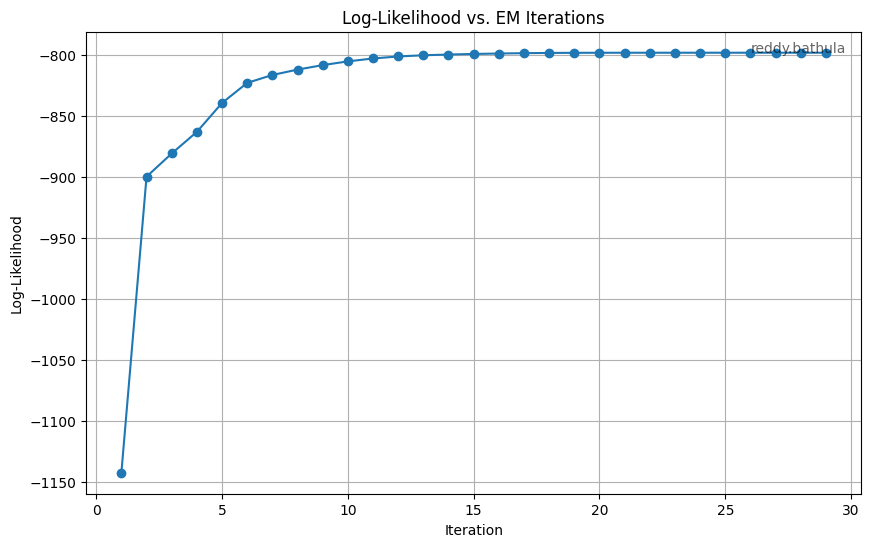

Optimal k found: 2 (based on Silhouette Score)


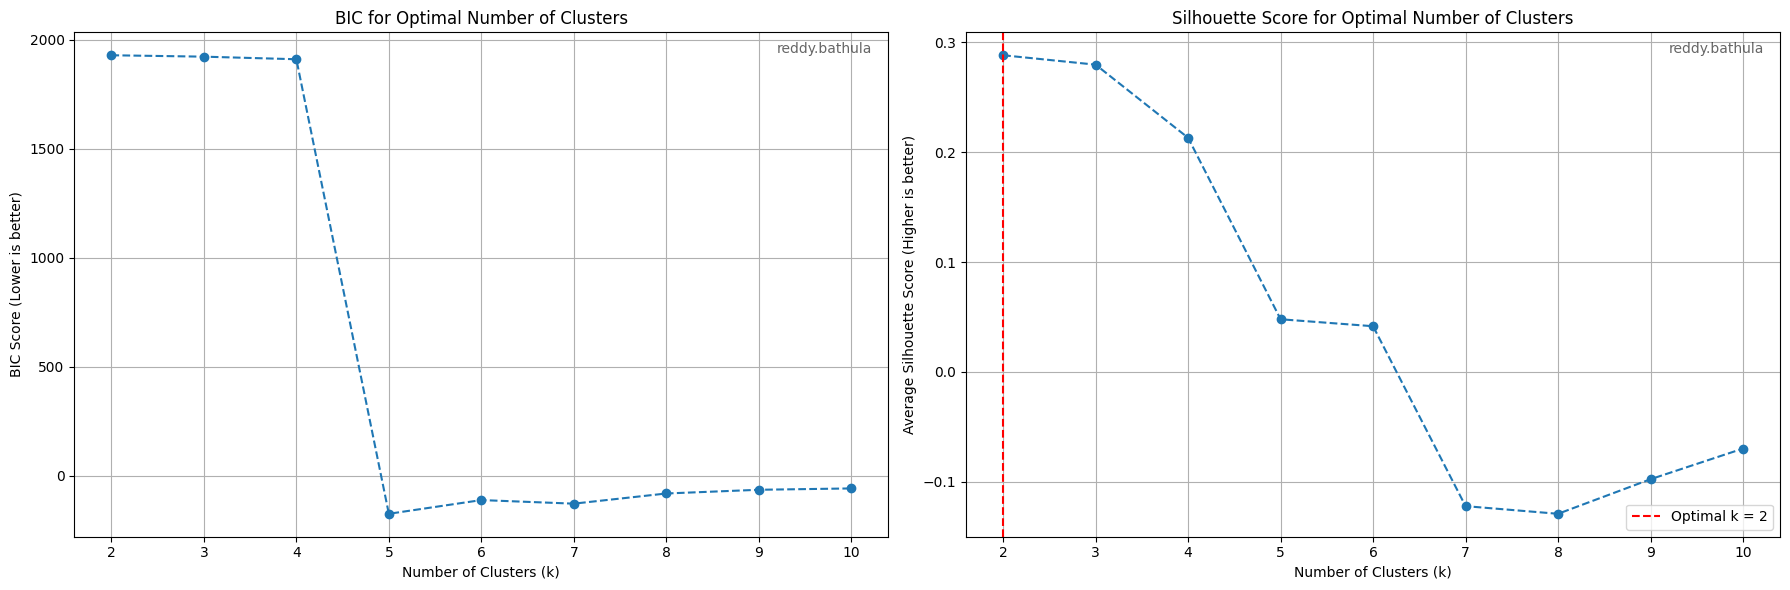

In [43]:
file_path = 'Dataset/Clustering_dataset.csv'
K = 5
analyzer = GMMAnalyzer(file_path=file_path, k=K, random_state=abs(hash(username)) % (2**32))
analyzer.run_pipeline()

### Bayesian Information Criterion
    - The BIC curve drops sharply at k=5 and then stabilizes
    - Since lower BIC is better, k=5 is the optimal choice.
    
### Silhouette Method
    - Score is highest at k=2
    - After 2, the score steadily declines, even turning negative around k=7-8.

In [ ]:
class SegmentImage:
    """Class to segment an image using GMM."""
    def __init__(self, image_path, k=3, random_seed=42, plot=True):
        self.image_path = image_path
        self.k = k
        self.random_state = random_seed
        self.processed_image, self.segmented_image = None, None
        self.colors = [[0.2,0.6,0.1],[0.1,0.3,0.8],[0.6,0.4,0.2]]
        self.h, self.w, self.d = None, None, None
        self.plot = plot

    def _preprocess_image(self):
        """Loads and normalizes the image."""
        image = plt.imread(self.image_path)
        image_normalized = image.astype(np.float64) / 255.0
        self.h, self.w, self.d = image.shape
        self.processed_image = image_normalized.reshape(-1, self.d)

    def _multivariate_normal(self, mean, cov, allow_singular=True):
        """Computes the multivariate normal density for each pixel."""
        x = self.processed_image
        mu = np.asarray(mean)
        Sigma = np.asarray(cov)
        d = len(mu)
        if allow_singular:
            Sigma = Sigma + np.eye(d) * 1e-8
        det = np.linalg.det(Sigma)
        if det <= 0:
            return np.zeros(x.shape[0])
        try:
            inv = np.linalg.inv(Sigma)
        except np.linalg.LinAlgError:
            return np.zeros(x.shape[0])
        diff = x - mu  
        mahalanobis = np.sum((diff @ inv) * diff, axis=1) 
        norm_const = 1.0 / np.sqrt((2 * np.pi) ** d * det)
        return norm_const * np.exp(-0.5 * mahalanobis)

    def _image_gmm(self):
        """Segments the image using GMM."""
        gmm = GMM(k=self.k, random_state=self.random_state)
        list(gmm.fit(self.processed_image))
        
        probs = np.zeros((self.processed_image.shape[0], self.k))
        for c in range(self.k):
            probs[:, c] = gmm.pi[c] * self._multivariate_normal(gmm.mu[c], gmm.sigma[c], allow_singular=True)
        labels = np.argmax(probs, axis=1)
        
        mean_brightness = [np.mean(mean) for mean in gmm.mu]
        sorted_indices = np.argsort(mean_brightness)
        colors = dict(zip(sorted_indices, self.colors))
        segmented_image_data = np.array([colors[label] for label in labels])
        self.segmented_image = segmented_image_data.reshape(self.h, self.w, self.d)

    def _visualize(self):
        """Visualizes the original and segmented images side by side."""
        if self.segmented_image is not None:
            original_image = plt.imread(self.image_path)
            fig, ax = plt.subplots(1, 2, figsize=(14, 7))
            
            ax[0].imshow(original_image)
            ax[0].set_title('Original Image') 
            ax[0].axis('off')
            watermark(ax[0])
            
            ax[1].imshow(self.segmented_image)
            ax[1].set_title('Segmented Image')
            ax[1].axis('off')
            watermark(ax[1])
            
            plt.suptitle(f"Image Segmentation for {self.image_path}", fontsize=16)
            plt.show()
        
    def run_pipeline(self):
        """Executes the full image segmentation pipeline."""
        self._preprocess_image()
        self._image_gmm()
        if self.plot:
            self._visualize()
        return

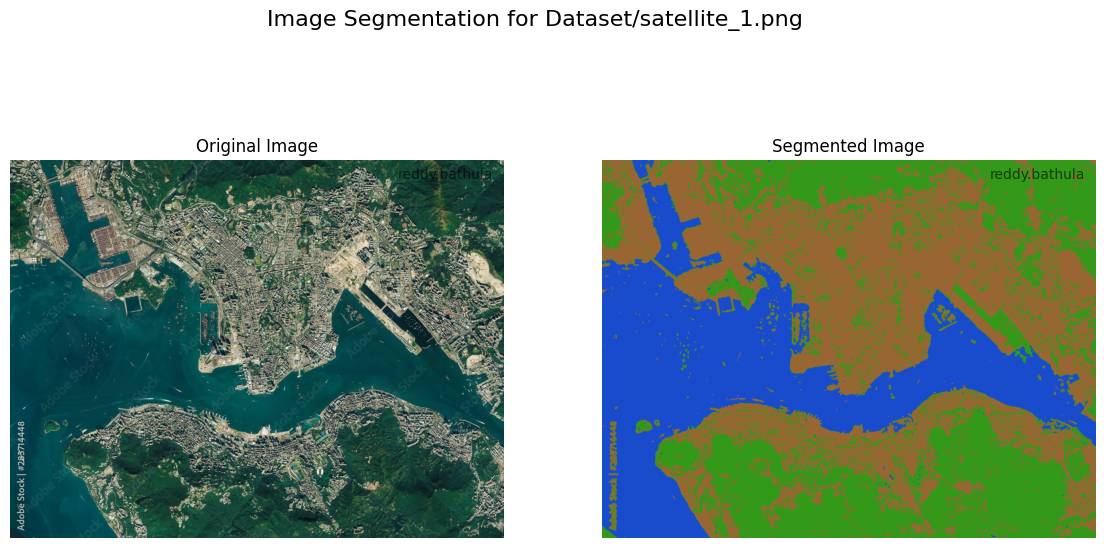

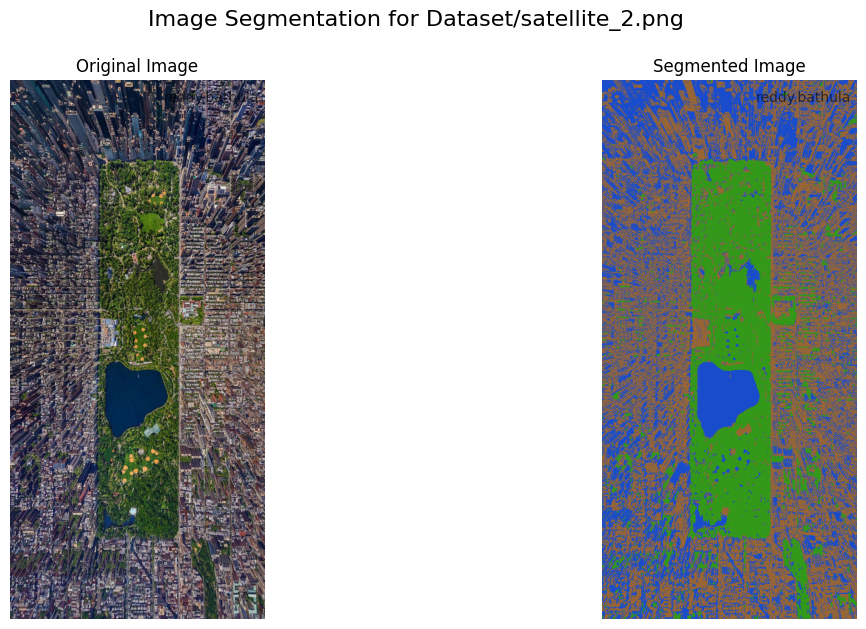

In [95]:
image_files = ['Dataset/satellite_1.png', 'Dataset/satellite_2.png']

for file in image_files:
    segmenter = SegmentImage(image_path=file)
    segmented_image = segmenter.run_pipeline()

In [34]:
class GMMVideoGenerator:  
    """Generates a video showing GMM segmentation convergence.""" 
    def __init__(self, k=3, random_state=42, fps=3, figsize=(21, 6)):
        self.k = k
        self.random_state = random_state
        self.fps = fps
        self.figsize = figsize
        self.original_image = None
        self.processed_data = None
        self.h, self.w, self.d = None, None, None
        
    def _load_and_preprocess_image(self, image_path):
        """Loads and preprocesses the image for GMM."""
        self.original_image = mpimg.imread(image_path)
        image_normalized = self.original_image.astype(np.float64) 
        self.h, self.w, self.d = self.original_image.shape
        self.processed_data = image_normalized.reshape(-1, self.d)

    def _setup_figure(self, image_name):
        """Set up the figure with three subplots."""
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=self.figsize)
        plt.tight_layout(pad=4.0)
        fig.suptitle(f'GMM Segmentation Convergence for {image_name}', fontsize=16)

        ax1.imshow(self.original_image)
        ax1.set_title('Panel 1: Original Image')
        ax1.axis('off')
        watermark(ax1)
        
        return fig, ax1, ax2, ax3
        
    def _create_update_function(self, gmm, ax2, ax3):
        """Creates the update function for the animation."""
        likelihood_history = []
        iteration_history = []
        
        def update_frame(frame_data):
            """Updates the animation frame."""
            iteration, log_likelihood, labels = frame_data
            segmented_data = gmm.mu[labels]
            segmented_data_clipped = np.clip(segmented_data, 0, 1)
            segmented_image = segmented_data_clipped.reshape(self.h, self.w, self.d)
            
            ax2.clear()
            ax2.imshow(segmented_image)
            ax2.set_title(f'Panel 2: Segmentation (Iteration {iteration + 1})')
            ax2.axis('off')
            watermark(ax2)

            iteration_history.append(iteration + 1)
            likelihood_history.append(log_likelihood)
            ax3.clear()
            ax3.plot(iteration_history, likelihood_history, 'r-o', markersize=4, linewidth=2)
            ax3.set_title('Panel 3: Log-Likelihood vs Iteration')
            ax3.set_xlabel('Iteration')
            ax3.set_ylabel('Log-Likelihood')
            ax3.grid(True, alpha=0.3)
            watermark(ax3)
            
            if len(likelihood_history) > 1:
                y_range = max(likelihood_history) - min(likelihood_history)
                y_padding = y_range * 0.1 if y_range > 0 else 1000
                ax3.set_ylim(min(likelihood_history) - y_padding, 
                            max(likelihood_history) + y_padding)
            ax3.set_xlim(0, min(50, gmm.max_iters + 1))  
        return update_frame
    
    def generate_video(self, image_path, output_filename):
        """Generates and saves the GMM convergence video."""
        self._load_and_preprocess_image(image_path)
        gmm = GMM(k=self.k, random_state=self.random_state, video=True)
        gmm_iterator = gmm.fit(self.processed_data)
        image_name = image_path.split("/")[-1]
        fig, ax1, ax2, ax3 = self._setup_figure(image_name)
        update_frame = self._create_update_function(gmm, ax2, ax3)

        anim = FuncAnimation(fig, update_frame, frames=gmm_iterator, 
                            repeat=True, save_count=gmm.max_iters)
        anim.save(output_filename, writer='pillow', fps=self.fps)
        plt.close(fig)
        
    def generate_multiple_videos(self, image_paths, output_prefix="convergence_video"):
        """Generates videos for multiple images."""
        for i, image_path in enumerate(image_paths):
            output_filename = f"{output_prefix}_{i+1}.gif"
            self.generate_video(image_path, output_filename)
            
video_gen = GMMVideoGenerator(k=3, random_state=42, fps=3)
video_gen.generate_multiple_videos(image_files, "convergence_videos")


Processing image 1/2: Dataset/satellite_1.png
Image shape: 767x1000x3
Data range: [0.000, 1.000]
Video saved successfully!

Processing image 2/2: Dataset/satellite_2.png
Image shape: 1600x755x3
Data range: [0.000, 1.000]
Video saved successfully!


## Links
- Satellite_1
    - https://iiithydresearch-my.sharepoint.com/:i:/g/personal/reddy_bathula_research_iiit_ac_in/EYEbxXAvs0FOrt1H-rxPvi0BQh5Ff9PY4jbmwhyU0c0DKg?e=86xUWU
- Satellite_2
    - https://iiithydresearch-my.sharepoint.com/:i:/g/personal/reddy_bathula_research_iiit_ac_in/EcDtHl1H6WZLjZoT_0XG0zoBqCBxcWyydLVdHIz4CPKqmQ?e=rJ3E5v